## Logistische Regression in Python - ein Beispiel
----------------------------------------

In [1]:
import folium
from folium.plugins import MarkerCluster
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import glm

%run ../src/notebook_env.py


---------------------------------
Working on the host: LAPTOP-9LETB4SJ

---------------------------------
Python version: 3.10.2 | packaged by conda-forge | (main, Mar  8 2022, 15:52:24) [MSC v.1929 64 bit (AMD64)]

---------------------------------
Python interpreter: C:\Users\zak\anaconda3\envs\srh\python.exe


Die logistische Regressionsanalyse gehört zur Klasse der <a href="https://de.wikipedia.org/wiki/Verallgemeinerte_lineare_Modelle">verallgemeinerten linearen Modelle</a>. In Python werden verallgemeinerte lineare Modelle mit der Funktion `GLM()` verarbeitet. Die Funktion wird als `GLM(y=Antwort, X=Prädiktor, family=sm.families.Binomial())` geschrieben. Bitte beachten Sie, dass `logit` die Vorgabe für binomial ist; wir müssen es also nicht explizit eingeben. Die Funktion `GLM()` gibt ein Modellobjekt zurück, auf das wir Extraktormethoden wie `summary()`, `fitted()` oder `predict()` anwenden können. Bitte beachten Sie jedoch, dass die ausgegebenen Zahlen auf der Logit-Skala liegen. Um tatsächlich Wahrscheinlichkeiten vorherzusagen, müssen wir der Funktion `predict()` ein zusätzliches Argument `type = 'response'` übergeben.

### Einführung und explorative Datenanalyse

Dieses Beispiel ist inspiriert von der Arbeit von <a href="https://myweb.fsu.edu/jelsner/_site/index.html">James B. Elsner</a> und seinen Kollegen (<a href="https://journals.ametsoc.org/view/journals/clim/9/11/1520-0442_1996_009_2880_ocoah_2_0_co_2.xml">Elsner et al. 1996</a> und <a href="https://journals.ametsoc.org/doi/10.1175/1520-0442-11.8.2062">Kimberlain und Elsner 1998</a>), die an der **Klassifizierung der nordatlantischen Hurrikane** auf der Grundlage von Entstehungs- und Entwicklungsmechanismen gearbeitet haben. Die Klassifizierung ergibt drei verschiedene Gruppen: tropische Wirbelstürme, Wirbelstürme unter baroklinem Einfluss und Wirbelstürme mit baroklinem Ursprung. Der Begriff "baroklin" bezieht sich auf die Tatsache, dass diese Hurrikane von Störungen der äußeren Tropen beeinflusst werden oder sogar in den äußeren Tropen entstehen. Die stärkeren tropischen Wirbelstürme entwickeln sich weiter südlich und treten hauptsächlich im August und September auf. Die schwächeren außertropischen Wirbelstürme treten während einer längeren Saison auf. Der ursprüngliche Datensatz zur objektiven Hurrikan-Klassifizierung kann <a href="https://myweb.fsu.edu/jelsner/temp/Data.html">hier</a> abgerufen werden. Die Analyse von James B. Elsner kann <a href="https://rpubs.com/jelsner/5206">hier</a> eingesehen werden.

**Ziel der Übung ist es, ein Modell zu erstellen, das die Gruppenzugehörigkeit eines Hurrikans, entweder tropisch oder nicht-tropisch, auf der Grundlage des Breitengrades seiner Entstehung vorhersagt.**

Wir beginnen die Analyse mit dem Laden des Datensatzes. Laden Sie die Daten auf Ihren Computer <a href="https://myweb.fsu.edu/jelsner/temp/Data.html">herunter</a> und öffnen Sie die Datei. Bitte beachten Sie, dass es sich bei der Datei um ein *Excel*-Tabelle handelt. Um mit *Excel*-Tabellen umgehen zu können benutzen wir `read_excel()` aus dem `Pandas` Paket.

In [6]:
hurricanes = pd.read_excel("hurricanes.xlsx")
hurricanes.head(5)

,RowNames,Number,Name,Year,Type,FirstLat,FirstLon,MaxLat,MaxLon,LastLat,LastLon,MaxInt
0,1,430,NOTNAMED,1944,1,30.2,-76.1,32.1,-74.8,35.1,-69.2,80
1,2,432,NOTNAMED,1944,0,25.6,-74.9,31.0,-78.1,32.6,-78.2,80
2,3,433,NOTNAMED,1944,0,14.2,-65.2,16.6,-72.2,20.6,-88.5,105
3,4,436,NOTNAMED,1944,0,20.8,-58.0,26.3,-72.3,42.1,-71.5,120
4,5,437,NOTNAMED,1944,0,20.0,-84.2,20.6,-84.9,19.1,-93.9,70


Zunächst untersuchen wir die Struktur des Datensatzes, indem wir die Methode `info()` anwenden.

In [7]:
hurricanes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337 entries, 0 to 336
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   RowNames  337 non-null    int64  
 1   Number    337 non-null    int64  
 2   Name      337 non-null    object 
 3   Year      337 non-null    int64  
 4   Type      337 non-null    int64  
 5   FirstLat  337 non-null    float64
 6   FirstLon  337 non-null    float64
 7   MaxLat    337 non-null    float64
 8   MaxLon    337 non-null    float64
 9   LastLat   337 non-null    float64
 10  LastLon   337 non-null    float64
 11  MaxInt    337 non-null    int64  
dtypes: float64(6), int64(5), object(1)
memory usage: 31.7+ KB


Der Datensatz besteht aus $337$ Beobachtungen und $12$ Variablen. Wir interessieren uns in erster Linie für die Variable `Type`, die unsere Antwortvariable ist, und für die Variable `FirstLat`, die dem Breitengrad der Entstehung entspricht und somit unsere Prädiktorvariable ist. Um jedoch ein Gefühl für den Datensatz zu bekommen, stellen wir die Anzahl der Hurrikane für jedes Jahr als Balkendiagramm mit dem `mathplotlib`-Paket dar.

<BarContainer object of 57 artists>

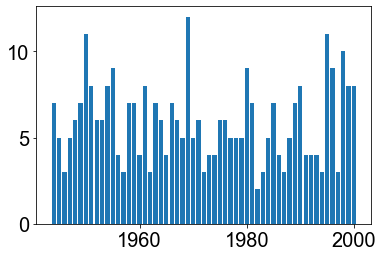

In [8]:
count = []

for i in range(1944,2001):
    count.append(list(hurricanes['Year']).count(i))

fig = plt.figure()
plt.bar(hurricanes['Year'].unique(),count)

Das ist eine schöne Darstellung. Wenn wir jedoch nur ein Argument hinzufügen, `stacked=True`, können wir die Balken zusätzlich entsprechend der Variable `Type` einfärben.

<AxesSubplot:xlabel='Jahr'>

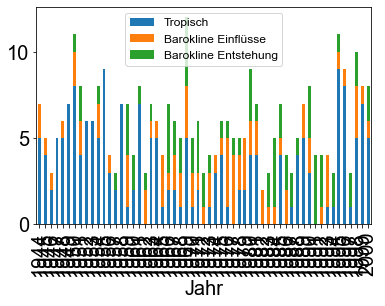

In [9]:
tropical = hurricanes.loc[hurricanes['Type'] == 0]
baroclinic_inf = hurricanes.loc[hurricanes['Type'] == 1]
baroclinic_int = hurricanes.loc[hurricanes['Type'] == 3]

count_tropical = []
count_baroclinic_inf = []
count_baroclinic_int = []

# Zähle Anzahl tropischer,barokline beeiflusster nud baroklin entstandener Hurrikans pro Jahr
for i in range(1944,2001):
    count_tropical.append(list(tropical['Year']).count(i))
    count_baroclinic_inf.append(list(baroclinic_inf['Year']).count(i))
    count_baroclinic_int.append(list(baroclinic_int['Year']).count(i))
    
# Erzeuge Dataframe
new = pd.DataFrame()
new['Jahr'] = hurricanes['Year'].unique()
new['Tropisch'] = count_tropical
new['Barokline Einflüsse'] = count_baroclinic_inf
new['Barokline Entstehung'] = count_baroclinic_int

new.plot(x='Jahr', kind='bar', stacked=True)

Für eine numerische Darstellung der Hurricane-Klassen verwenden wir die Methode `sum()`.

In [10]:
print('Klasse 0 Hurrikans :',new['Tropisch'].sum())
print('Klasse 1 Hurrikans :',new['Barokline Einflüsse'].sum())
print('Klasse 3 Hurrikans :',new['Barokline Entstehung'].sum())

Klasse 0 Hurrikans : 187
Klasse 1 Hurrikans : 77
Klasse 3 Hurrikans : 73


Für die **Klasse** $0$, *tropische Wirbelstürme*, gibt es $187$ Beobachtungen, für die **Klasse** $1$, *barokline Einflüsse*, gibt es $77$ Beobachtungen und für die **Klasse** $3$, *barokline Auslösung*, gibt es $73$ Beobachtungen. Bei der logistischen Regression haben wir es mit dichotomen Daten zu tun; der Einfachheit halber kodieren wir die Klassen neu und weisen der Klasse $1$ und der Klasse $3$, die beide von den äußeren Tropen beeinflusst werden, die Bezeichnung $1$ zu.

In [11]:
hurricanes_new = hurricanes
hurricanes_new['Type_new'] = hurricanes_new['Type'].replace([3], 1)

Wir haben nun eine binäre Antwortvariable mit zwei Klassen: Die Klasse $0$ entspricht den *tropischen* Wirbelstürmen und die Klasse $1$ den *nicht-tropischen* Wirbelstürmen. Prüfen wir die Klassenverteilung unserer neuen Antwortvariablen `Type_new`.

In [12]:
tropical = hurricanes_new.loc[hurricanes_new['Type_new'] == 0]
non_tropical = hurricanes_new.loc[hurricanes_new['Type_new'] == 1]
print('Klasse 0 Hurrikans :',tropical['Type_new'].count())
print('Klasse 1 Hurrikans :',non_tropical['Type_new'].count())

Klasse 0 Hurrikans : 187
Klasse 1 Hurrikans : 150


Um diesen Teil der explorativen Datenanalyse abzuschließen, stellen wir die Daten auf einer interaktiven Karte dar, indem wir das `folium`-Paket verwenden.

In [13]:
#Create the map
my_map = folium.Map(location=[51.144, 9.902],
                        zoom_start=2,
                        )
tropical = hurricanes_new.loc[hurricanes_new['Type_new']==0]
non_tropical = hurricanes_new.loc[hurricanes_new['Type_new']==1]

# add marker one by one on the map
for i in range(0,len(tropical)):
    folium.Marker(location=[tropical.iloc[i]['FirstLat'], tropical.iloc[i]['FirstLon']],icon = folium.Icon(color=('green'))).add_to(my_map)
for i in range(0,len(non_tropical)):
    folium.Marker(location=[non_tropical.iloc[i]['FirstLat'], non_tropical.iloc[i]['FirstLon']],icon = folium.Icon(color=('red'))).add_to(my_map)

# Show the map again
my_map

### Logistische Regression: Modellanpassung

Erinnern Sie sich an das Ziel der Übung: Wir wollen ein Modell erstellen, das die Gruppenzugehörigkeit eines Hurrikans vorhersagt, entweder tropisch ($0$) oder nicht-tropisch ($1$), basierend auf dem Breitengrad der Entstehung des Hurrikans. Die Antwortvariable ist die binäre Variable `Typ_new` und die Prädiktorvariable ist `FirstLat`. Wir erstellen ein Logit-Modell, indem wir die Funktion `GLM()` anwenden. Für das logistische Regressionsmodell geben wir `family = sm.families.Binomial()` an.

In [14]:
X = hurricanes_new['FirstLat'].values
X = sm.add_constant(X)
y = hurricanes_new['Type_new'].values
log_model = sm.GLM(y, X, family=sm.families.Binomial())
log_results = log_model.fit()

Wir verwenden die Extraktormethode `summary()`, um die Modelleigenschaften zu überprüfen.

In [15]:
log_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  337
Model:                            GLM   Df Residuals:                      335
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -116.02
Date:                Sun, 29 May 2022   Deviance:                       232.03
Time:                        10:23:43   Pearson chi2:                     430.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4963
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.0826      0.961     -9.446      0.000     -10.967      -7.198
x1             0.3728      0.039      9.447      0.000       0.295       0.450
==============================================================================
"""

Schauen wir uns die Koeffizienten genauer an:

In [75]:
log_results.params

array([-9.08263355,  0.37282953])

Beachten Sie, dass die Ausgabe des logistischen Modells auf der Link-Skala (*logit*) erfolgt; die numerische Ausgabe des Modells entspricht also den **Log-Odds**! Der Einfachheit halber schreiben wir das logistische Regressionsmodell mit dem berechneten Achsenabschnitt und Koeffizienten auf.

$$\phi(\eta) = \frac{1}{1+e^{-\eta}}= \frac{1}{1+e^{-\beta_0+\beta_1x_1}}= \frac{1}{1+e^{-(-9,0826335+ 0,3728295x)}}$$

Konzentrieren wir uns zunächst auf den Koeffizienten des Achsenabschnitts. Der Koeffizient des Achsenabschnitts entspricht der logarithmischen Wahrscheinlichkeit der Beobachtung eines Hurrikans auf dem Breitengrad Null, der als Äquator bekannt ist. Um die Wahrscheinlichkeit der Beobachtung eines nicht-tropischen Hurrikans bei einem Breitengrad von Null zu berechnen, potenzieren wir die log-odds $e^{-9.0826335} = 1.1362198\times 10^{-4}$. 

Dies ist eine sehr niedrige Zahl! Und sie macht durchaus Sinn, da es sehr unwahrscheinlich ist, einen nicht-tropischen Hurrikan am Äquator zu beobachten.

Der Koeffizient der Variable für die Bildungsbreite (`FirstLat`) hat einen numerischen Wert von $0,3728295$. Das positive Vorzeichen dieses Wertes zeigt an, dass die Wahrscheinlichkeit, einen außertropischen Wirbelsturm zu beobachten, mit dem Breitengrad zunimmt. Die Größe des Koeffizienten bedeutet, dass die Log-Odds für jedes Grad Zunahme der geografischen Breite im Durchschnitt um konstant $0,3728295$ Einheiten zunimmt. Wenn man den Koeffizientenwertes als Exponenten nimmt, erhält man das Odds Verhältnis.

In [76]:
math.exp(0.3728295)

1.4518367805578616

Somit erhöht sich das Chancenverhältnis für jedes Grad Zunahme der Bildungsbreite im Durchschnitt um einen konstanten Faktor von $1,4518368$ (oder $45 \%$). Die Interpretation gilt nur für den Bereich der Breitengrade in den Daten und ist für Breitengrade außerhalb des Bereichs, in dem Hurrikane auftreten, physikalisch bedeutungslos.

Die obige Koeffiziententabelle enthält einen Standardfehler und den $p$-Wert. Je kleiner der $p$-Wert ist, desto geringer ist die Unterstützung für die Nullhypothese angesichts der Daten und des Modells. Zur Erinnerung: Die Nullhypothese besagt, dass der Koeffizient gleich $0$ ist,
mit anderen Worten, die Nullhypothese besagt, dass es keinen Zusammenhang zwischen dem Auftreten eines nichttropischen Hurrikans und der Entstehungsbreite gibt. Der sehr kleine $p$-Wert stützt die Nullhypothese nicht und erlaubt uns, das Modell zu akzeptieren.

Wir haben gelernt, dass jede Punktschätzung von einem Konfidenzniveau bezüglich dieser Punktschätzung begleitet sein sollte. Daher konstruieren wir ein $95 \%$-Konfidenzintervall für den geschätzten Modellkoeffizienten. Wir potenzieren das Ergebnis, um das Odds-Ratio zu erhalten, eine Größe, die leichter zu interpretieren ist als die Log-Odds.

In [77]:
print('2,5 % :',0.295,'97,5 % :',0.450)

2,5 % : 0.295 97,5 % : 0.45


In [78]:
print('2,5 % :',math.exp(0.295),'97,5 % :',math.exp(0.450))

2,5 % : 1.3431263586862767 97,5 % : 1.568312185490169


Wir können also mit $95 \%$iger Sicherheit sagen, dass für jedes Grad Zunahme der Bildungsbreite die Beobachtung eines nicht-tropischen Hurrikans im Durchschnitt zwischen $34$ und $57 \%$ wahrscheinlicher wird.

### Logistische Regression: Modellvorhersage

Im vorangegangenen Abschnitt haben wir ein logistisches Regressionsmodell für die Beziehung zwischen der Entstehungsbreite und der Art des Hurrikans (tropisch/nicht-tropisch) erstellt. In diesem Abschnitt wenden wir dieses Modell an, um Vorhersagen über die Wahrscheinlichkeit der Beobachtung eines nicht-tropischen Hurrikans in Abhängigkeit von der Entstehungsbreite zu machen.

Um die Wahrscheinlichkeit vorherzusagen, dass ein zufällig ausgewählter Hurrikan, der sich auf einem bestimmten Breitengrad bildet, vom Typ nicht-tropisch ist, wenden wir die Funktion `predict()` an. Berechnen wir die Wahrscheinlichkeit, einen nicht-tropischen Hurrikan zu beobachten, der sich bei folgenden Breitengraden gebildet hat : $10^\circ, 23,5^\circ \text{und }30^\circ$

In [21]:
pred = [10.,23.5,30.]#
pred = sm.add_constant(pred)
predictions = log_results.get_prediction(exog = pred).summary_frame()
round(predictions['mean'],9)

0    0.004705
1    0.420398
2    0.891122
Name: mean, dtype: float64

Die Ergebnisse machen durchaus Sinn. Mit zunehmender geografischer Breite nimmt die Wahrscheinlichkeit, die Bildung eines nichttropischen Hurrikans zu beobachten, deutlich zu. Bei einem Breitengrad von $10^\circ$ beträgt die Wahrscheinlichkeit der Beobachtung eines außertropischen Hurrikans $0,005$, während sie bei einem Breitengrad von $30^\circ$ $0,891$ beträgt.

Zum besseren Verständnis wollen wir die Wahrscheinlichkeit der Beobachtung eines nichttropischen Hurrikans, der sich bei einem Breitengrad von $23,5^\circ$
von Hand. Erinnern wir uns an die Gleichung für das Regressionsmodell von oben:

\begin{align}
\ \phi(\eta) & = \frac{1}{1+e^{-\eta}} = \frac{1}{1+e^{-\beta_0+\beta_1x_1}}\\
 & = \frac{1}{1+e^{-(-9,0826335+ 0,3728295 \times 23,5)}} \\
 & = \frac{1}{1+e^{-(-0,3211396)}} \\ 
 & = \frac{1}{2,378698}  = 0,4203981
\end{align}

Zur Veranschaulichung unserer Ergebnisse erstellen wir ein Diagramm der Vorhersagen über eine Reihe von Breitengraden. Dazu erstellen wir zunächst einen Vektor der Breitengrade, `lats`. Wir geben eine Schrittweite von $0,1$ Grad an, damit die resultierende Vorhersagekurve glatt ist. Wir wenden die Funktion `predict()` an und verwenden die Methode `get_prediction()`, um den **Standardfehler** der Vorhersage zu erhalten. Die Kenntnis des Standardfehlers ermöglicht die Berechnung der **Fehlermarge** und damit des **Konfidenzintervalls**. Mit der Methode `summary_frame()` können wir die Werte in einem Dataframe ausgeben und darauf zugreifen. Schließlich zeichnen wir die Datenpunkte (Beobachtungen) bei $0$ und $1$ ein und fügen die vorhergesagten Werte mit der Funktion `axhlines()` hinzu.

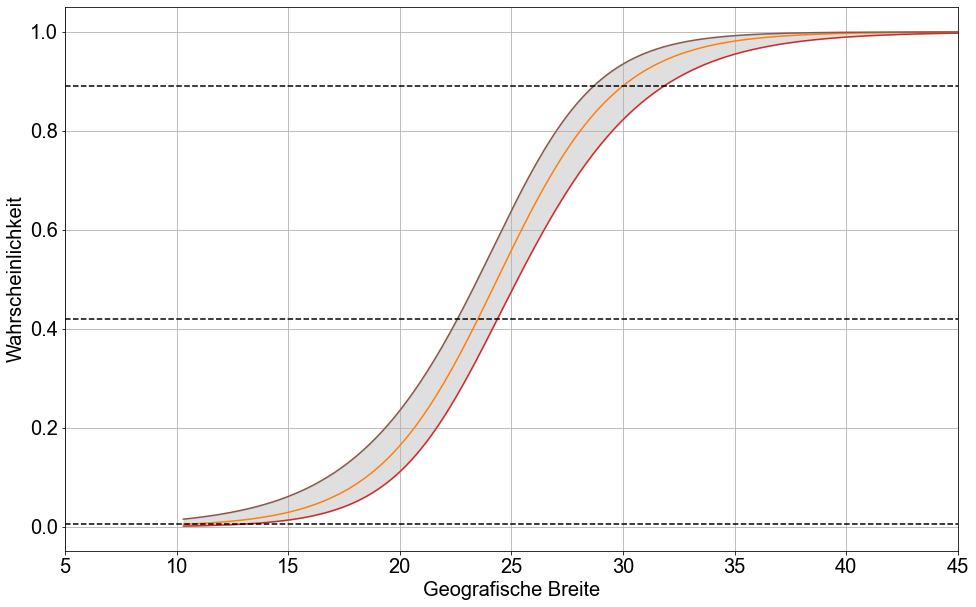

In [80]:
# Berechne Vorhersagen für lats
lats = np.linspace(min(hurricanes_new['FirstLat']),max(hurricanes_new['FirstLat']), num = 337)
lats_grid = lats
X = hurricanes_new['FirstLat'].values
X = sm.add_constant(X)
lats = sm.add_constant(lats)
y = hurricanes_new['Type_new'].values
log_model = sm.GLM(y, X, family=sm.families.Binomial())
log_results = log_model.fit()
predictions = log_results.get_prediction(exog = lats).summary_frame()

# Formatiere Plots
fig, ax = plt.subplots()
ax.plot(lats,predictions['mean'])
ax.plot(lats,predictions['mean_ci_lower'])
ax.plot(lats,predictions['mean_ci_upper'])

ax.fill_between(lats_grid,predictions['mean_ci_lower'], predictions['mean_ci_upper'],color = 'grey', alpha = 0.25)
plt.xlim(5,45)
plt.axhline(y=0.005,linestyle = '--',color = 'k')
plt.axhline(y=0.42,linestyle = '--',color = 'k')
plt.axhline(y=0.891,linestyle = '--',color = 'k')
plt.grid()
plt.xlabel("Geografische Breite")
plt.ylabel("Wahrscheinlichkeit")
plt.show()

Die Beobachtungen tropischer und nicht-tropischer Hurrikane sind entlang der Linien $y=0$ bzw. $y=1$ Linien dargestellt. Das graue Band ist das $95 \%$ige punktweise Konfidenzintervall.

Die Modellvorhersagen zeigen, dass die Wahrscheinlichkeit eines nichttropischen Hurrikans bei Breitengraden südlich von $20^\circ N$ weniger als $10 \%$ beträgt. Bis zum Breitengrad $26^\circ N$ übersteigt die Wahrscheinlichkeit jedoch $50 \%$ und bis zum Breitengrad $33^\circ N$ übersteigt die Wahrscheinlichkeit $90 \%$. Das Chancenverhältnis ist konstant, aber die Wahrscheinlichkeit ist eine nichtlineare Funktion des Breitengrads.